## Import libraries

In [ ]:
import os
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

client = ESMC.from_pretrained("esmc_600m").to("cuda")

/n/home06/tbush/envs/esm/lib/python3.12/site-packages/esm/pretrained.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [2]:
import sys, os
sys.path.append(os.path.abspath(".."))

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import matplotlib.pyplot as plt
import torch 

## Dataset GFP

In [4]:
# we can create the dataset:
data_dir = Path("/n/home06/tbush/gfp_function_prediction/data/raw_data")
sequence_path =  data_dir / "P42212.fasta.txt"
original_dataset_path = data_dir / "amino_acid_genotypes_to_brightness.tsv"
# load the dataset
gfp_dataset_original = pd.read_csv(original_dataset_path, sep="\t")

In [5]:
# load utilities functions 
from utils.utils import parse_mutation, mutate_seq, get_numb_mut, load_seq_
def mutate_sequence(mutation_string, seq, mapping_db_seq):
    if pd.isna(mutation_string):
        return None
    try:
        mutations = mutation_string.split(":")
        for m in mutations:
            src, idx, dest = parse_mutation(m)
            if idx in mapping_db_seq:
                mapped_idx = mapping_db_seq[idx]
                mutated_seq = seq[:mapped_idx] + dest + seq[mapped_idx + 1 :]
                return mutated_seq
    except Exception:
        return None
    return None

    # Calculate the original distribution of num_mut
    def get_numb_mut(mut: str) -> int:
        if type(mut) == str:
            n = len(mut.split(":"))
        else:
            return 0
        return n

In [6]:
seq, mapping = load_seq_(sequence_path)
gfp_dataset_original["seq_mutated"] = gfp_dataset_original["aaMutations"].apply(
    lambda muts: mutate_sequence(muts, seq=seq, mapping_db_seq=mapping)
)
gfp_dataset_original["num_mut"] = gfp_dataset_original['aaMutations'].apply(lambda mut: get_numb_mut(mut))

## LLR Metric Computation

In [8]:
# now we load the model + utilities for calculuting the LLR metrics
from esm.sdk.api import ESMProtein, LogitsConfig
import ipywidgets as widgets
from IPython.display import display
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [9]:
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
client = ESMC.from_pretrained("esmc_600m").to("cuda")
def token_id(x: str, client) -> int:
    enc = client.encode(ESMProtein(x))
    return int(enc.sequence[1])  # BOS at 0, your token at 1, EOS at 2
aa_ids = {a: token_id(a, client=client) for a in amino_acids}
mask_id = token_id("<mask>", client=client)

/n/home06/tbush/envs/esm/lib/python3.12/site-packages/esm/pretrained.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [22]:
def generate_heatmap(protein_sequence:str, start_pos:int=1, end_pos=None):

  # load model and tokenizer
  forge_client = ESMC.from_pretrained("esmc_600m").to("cuda")
  aa_ids = {'A': 5,
            'C': 23,
            'D': 13,
            'E': 9,
            'F': 18,
            'G': 6,
            'H': 21,
            'I': 12,
            'K': 15,
            'L': 4,
            'M': 20,
            'N': 17,
            'P': 14,
            'Q': 16,
            'R': 10,
            'S': 8,
            'T': 11,
            'V': 7,
            'W': 22,
            'Y': 19}

  # tokenize the input sequence
  protein = ESMProtein(protein_sequence)
  input_ids = forge_client.encode(protein)
  sequence_length = len(protein_sequence)

  if end_pos is None:
    end_pos = sequence_length

  # list aminoacids
  amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

  #initialize the heatmap
  heatmap = np.zeros((20, end_pos - start_pos + 1))

  # calculate LLRs for each position and aminoacid:
  for position in range(start_pos, end_pos +1):
    # make masked sequence
    i = position -1
    masked_seq = protein_sequence[:i] + "<mask>" + protein_sequence[i+1:]
    protein = ESMProtein(masked_seq)
    enc = forge_client.encode(protein)

    # get per-position logits
    out = forge_client.logits(
    enc, LogitsConfig(sequence=True, return_embeddings=True))

    # identify the masked-token index in logits:
    masked_tok_idx = position
    masked_logits = out.logits.sequence.squeeze()[masked_tok_idx]

    # get log probs:
    log_probs = torch.log(F.softmax(masked_logits, dim=-1))

    # wt residue
    wt_residue = protein_sequence[position-1]
    wt_id = aa_ids[wt_residue]
    log_prob_wt = log_probs[wt_id].item()

    # LLR for the residues
    for i, aa in enumerate(amino_acids):
      mt_id = aa_ids[aa]
      log_prob_mt = log_probs[mt_id].item()
      heatmap[i, position-start_pos] = log_prob_mt - log_prob_wt

  # visualize the heatmap
  plt.figure(figsize=(15, 5))
  plt.imshow(heatmap, cmap="viridis", aspect="auto")
  plt.xticks(range(end_pos - start_pos + 1), list(protein_sequence[start_pos-1:end_pos]))
  plt.yticks(range(20), amino_acids)
  plt.xlabel("Position in Protein Sequence")
  plt.ylabel("Amino Acid Mutations")
  plt.title("Predicted Effects of Mutations on Protein Sequence (LLR)")
  plt.colorbar(label="Log Likelihood Ratio (LLR)")
  plt.show()
  return heatmap


/n/home06/tbush/envs/esm/lib/python3.12/site-packages/esm/pretrained.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


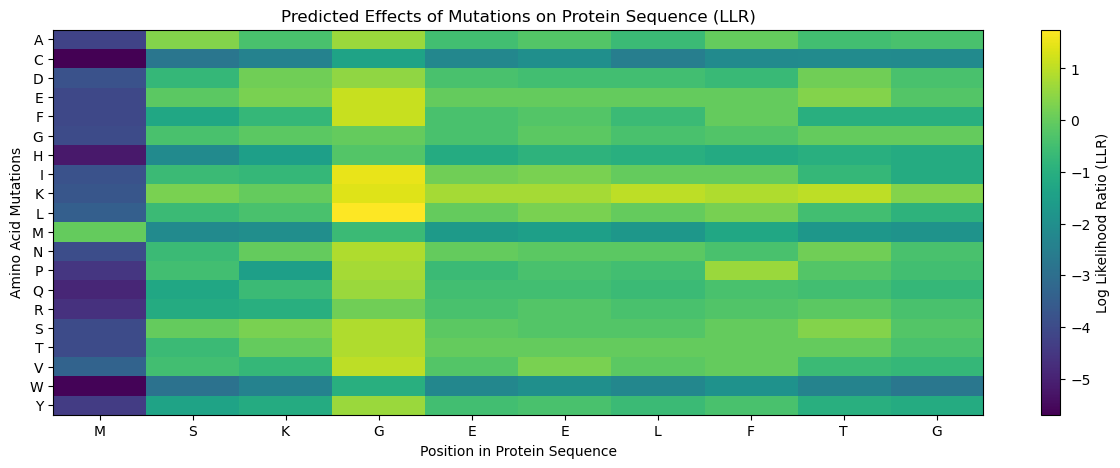

In [23]:
heatmap = generate_heatmap(seq, end_pos=10)

### Function to get embedding and P of a mutated sequence:

In [ ]:
def get_embedding(sequence:str, client:ESMC):
    protein = ESMProtein(sequence)
    enc = client.encode(protein)
    out = client.logits(
        enc, LogitsConfig(sequence=True, return_embeddings=True))
    return out.logits.sequence, out.embeddings 

In [52]:
wt_logits, _  = get_embedding(seq, client)   # (1, L, V)
mut_logits, _ = get_embedding(gfp_dataset_original["seq_mutated"].values[150], client)

In [68]:

def logits_to_logprobs(logits: torch.Tensor) -> torch.Tensor:
    """
    logits: (1, L, V) or (L, V) [bf16 on GPU is common]
    returns: (L, V) float32 log-probabilities
    """
    if logits.dim() == 3:
        logits = logits.squeeze(0)
    return torch.log_softmax(logits.float(), dim=-1)

def run_logprobs(seq: str, client) -> torch.Tensor:
    """
    One forward pass -> (L_logits, V) float32 log-probs on CPU.
    L_logits may include BOS/EOS; use align_positions() to match sequence length.
    """
    from esm.sdk.api import ESMProtein, LogitsConfig
    enc = client.encode(ESMProtein(seq))
    out = client.logits(enc, LogitsConfig(sequence=True, return_embeddings=False))
    return logits_to_logprobs(out.logits.sequence).cpu()

def align_positions(lp: torch.Tensor, L_seq: int) -> torch.Tensor:
    """
    Ensure lp has exactly L_seq rows (drop BOS/EOS if present).
    Common cases:
      - lp.shape[0] == L_seq + 2 -> return lp[1:-1]
      - lp.shape[0] == L_seq     -> return lp
    Otherwise, try a centered slice if longer; error if shorter.
    """
    L_logits = lp.shape[0]
    if L_logits == L_seq:
        return lp
    if L_logits == L_seq + 2:
        return lp[1:-1]  # drop BOS & EOS
    if L_logits > L_seq:
        start = (L_logits - L_seq) // 2
        return lp[start:start + L_seq]
    raise ValueError(f"Logits length {L_logits} < sequence length {L_seq}; cannot align.")

def find_mutations(wt: str, mt: str):
    assert len(wt) == len(mt), "WT and MT must have same length"
    return [(i, a, b) for i, (a, b) in enumerate(zip(wt, mt)) if a != b]

# ---------- main: WT vs MT comparison & plots ----------
def compare_sequences_full(
    wt_seq: str,
    mt_seq: str,
    client,
    aa_to_idx: dict,
    amino_acids: str = "ACDEFGHIKLMNPQRSTVWY",
):
    """
    Plots:
      (A) sequence-wide WT vs MT track of logP(realized residue)
      (B) ΔlogP heatmap across 20 amino acids: logP_MT - logP_WT

    Returns dict with arrays if you want to reuse the results.
    """
    assert len(wt_seq) == len(mt_seq), "WT and MT must have same length."
    L_seq = len(wt_seq)

    # 1) Log-probs (may include BOS/EOS) -> align to sequence length
    wt_lp_full = run_logprobs(wt_seq, client)     # (L_logits, V)
    mt_lp_full = run_logprobs(mt_seq, client)     # (L_logits, V)
    wt_lp = align_positions(wt_lp_full, L_seq)    # (L_seq, V)
    mt_lp = align_positions(mt_lp_full, L_seq)    # (L_seq, V)

    # 2) Sequence-wide tracks: model confidence in realized residue at each site
    wt_track = np.array([wt_lp[i, aa_to_idx[aa]].item() for i, aa in enumerate(wt_seq)])
    mt_track = np.array([mt_lp[i, aa_to_idx[aa]].item() for i, aa in enumerate(mt_seq)])

    # 3) Plot tracks with mutation annotations
    x = np.arange(1, L_seq + 1)
    muts = find_mutations(wt_seq, mt_seq)

    plt.figure(figsize=(12, 4))
    plt.plot(x, wt_track, label="WT: logP(wt residue)", linewidth=1.5)
    plt.plot(x, mt_track, label="MT: logP(mut residue)", linewidth=1.5)
    for i, a, b in muts:
        dlp = float(mt_lp[i, aa_to_idx[b]] - wt_lp[i, aa_to_idx[a]])
        plt.scatter([i + 1], [mt_track[i]], s=35)
        plt.vlines(i + 1, min(wt_track[i], mt_track[i]), max(wt_track[i], mt_track[i]),
                   linestyles="dotted", linewidth=1)
        plt.text(i + 1, mt_track[i], f"{a}→{b}\nΔ{dlp:+.2f}",
                 ha="center", va="bottom", fontsize=8)
    plt.axhline(0.0, linewidth=1, alpha=0.4)
    plt.xlabel("Position (1-based)")
    plt.ylabel("log-probability")
    plt.title("Model confidence in realized residues (WT vs MT)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 4) ΔlogP heatmap across the 20 amino acids only (cleaner, no special tokens)
    aa_cols = [aa_to_idx[a] for a in amino_acids]
    dlp_matrix = (mt_lp - wt_lp).numpy()[:, aa_cols]   # (L_seq, 20)

    plt.figure(figsize=(14, 4))
    plt.imshow(dlp_matrix.T, aspect="auto", interpolation="nearest")
    plt.colorbar(label="Δ logP (MT − WT)")
    plt.yticks(range(len(amino_acids)), list(amino_acids))
    plt.xlabel("Position")
    plt.ylabel("Amino acid")
    plt.title("Whole-sequence distribution shift (20 AA): logP_MT − logP_WT")
    plt.tight_layout()
    plt.show()

    # 5) Numeric per-mutation summary
    effects = []
    for i, a, b in muts:
        d = float(mt_lp[i, aa_to_idx[b]] - wt_lp[i, aa_to_idx[a]])
        effects.append({"pos": i + 1, "wt": a, "mut": b, "delta_logP": d})
    if effects:
        print("Per-mutation ΔlogP (mut vs wt at site):")
        for e in effects:
            print(f"  pos {e['pos']:>4}  {e['wt']}→{e['mut']}   ΔlogP = {e['delta_logP']:+.3f}")
    else:
        print("No sequence differences detected (WT == MT).")

    return {
        "wt_logprobs": wt_lp,                # torch (L_seq, V)
        "mt_logprobs": mt_lp,                # torch (L_seq, V)
        "delta_matrix_20aa": dlp_matrix,     # np (L_seq, 20) in amino_acids order
        "wt_track": wt_track,                # np (L_seq,)
        "mt_track": mt_track,                # np (L_seq,)
        "mutations": effects,                # list of dicts
    }


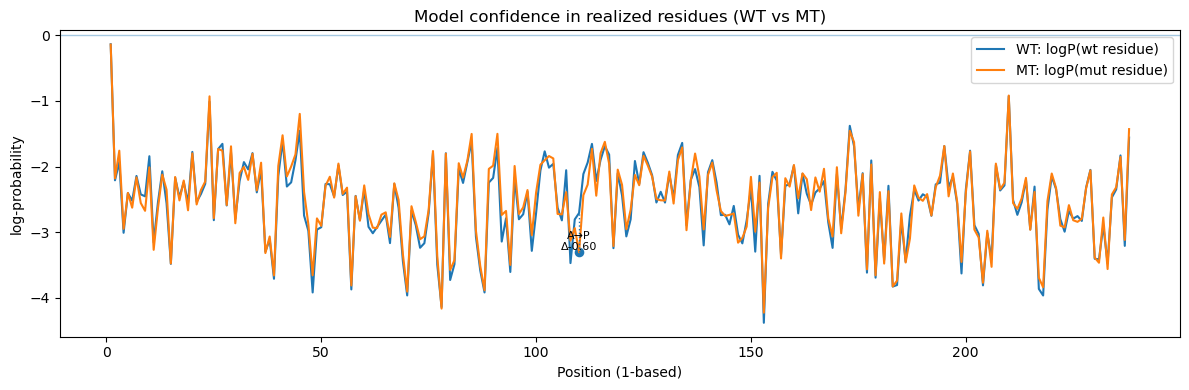

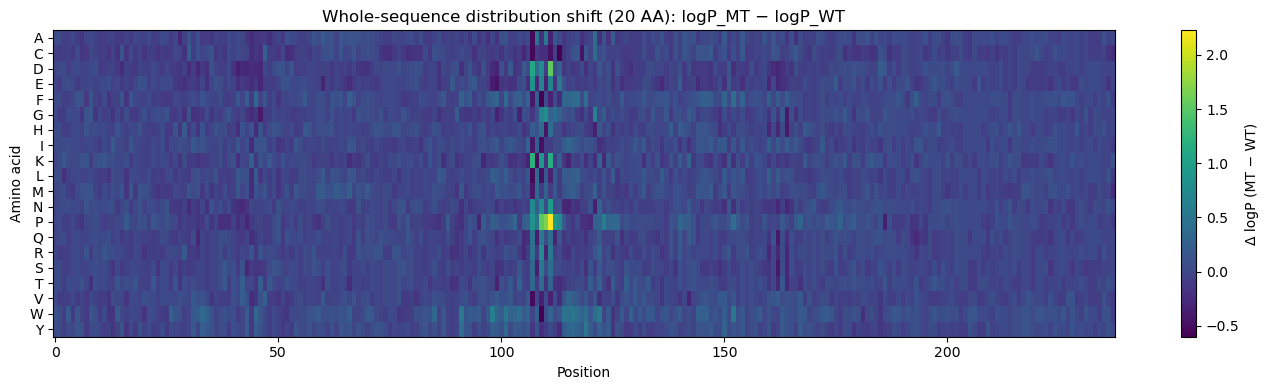

Per-mutation ΔlogP (mut vs wt at site):
  pos  110  A→P   ΔlogP = -0.598


In [76]:
# Your 20-AA index map (must match model vocab indices)
aa_to_idx = {'A':5,'C':23,'D':13,'E':9,'F':18,'G':6,'H':21,'I':12,'K':15,'L':4,
             'M':20,'N':17,'P':14,'Q':16,'R':10,'S':8,'T':11,'V':7,'W':22,'Y':19}


res = compare_sequences_full(seq, gfp_dataset_original["seq_mutated"].values[9], client, aa_to_idx)


In [ ]:
gfp_dataset_original.head(1)

,aaMutations,uniqueBarcodes,medianBrightness,std,seq_mutated,num_mut
0,NaN,3645,3.719212,0.106992,None,0
1,SA108D,1,1.301030,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,5
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,4
4,SA108G,2,3.708478,0.020613,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1
5,SA108G:SK138M:SR166C:SL234P,1,3.582764,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,4
6,SA108G:SK154E:SF163S:SL192Q:SL193P,1,1.499573,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,5
7,SA108G:SK156R,1,3.659013,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,2
8,SA108G:SK156R:SI159V:SI186V:ST223S,1,3.573855,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,5
9,SA108P:SK111R:SG172S:SL176P:SS200G,1,1.301031,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,5
